In [1]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import random_split
 
from tqdm.notebook import tqdm

ip = get_ipython()
ip.sphinxify_docstring = True
ip.enable_html_pager = True

In [2]:
dataset = QM9(root='/tmp/QM9')

PyTorch Geometric requires certain attributes to be present in the dataset. For example
- `x` should contain node features
- 'edge_attr` edge freatures
- `edge_index` edge list
- `y` labels

The QM9 dataset also has
- `pos` the 3D position of each atom
- `z` the atomic number of each atom

We're going to train on QM9 to predict isotropic polarization.

In [3]:
import networkx as nx

In [4]:
G = nx.from_edgelist(dataset[42]["edge_index"].T.numpy())

In [5]:
dataset[42]

Data(x=[12, 11], edge_index=[2, 24], edge_attr=[24, 4], y=[1, 19], pos=[12, 3], idx=[1], name='gdb_43', z=[12])

In [6]:
dataset[42].edge_index.numpy()

array([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,
         4,  5,  6,  7,  8,  9, 10, 11],
       [ 1,  4,  5,  6,  0,  2,  3,  7,  1,  3,  8,  9,  1,  2, 10, 11,
         0,  0,  0,  1,  2,  2,  3,  3]])

In [7]:
sizes = dataset[42]["z"].numpy()

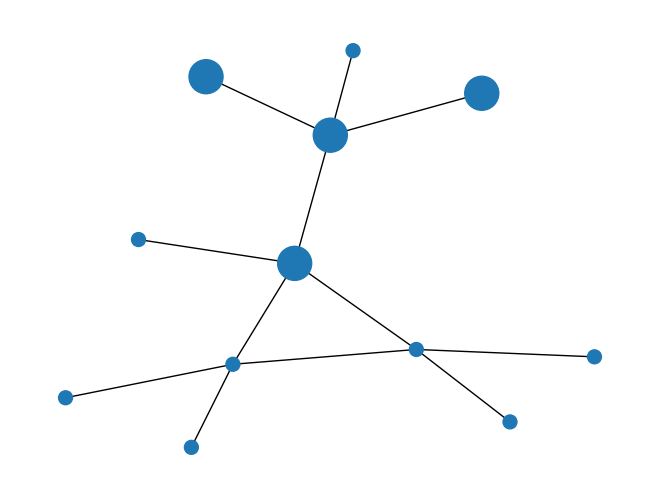

In [8]:
nx.draw(G,node_size=100*sizes,label=sizes)

In [9]:
class GCN(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        
        convC1 = nn.Sequential(
            nn.Linear(num_edge_features,32),
            nn.SiLU(),
            nn.Linear(32,num_node_features*num_node_features)
        ) # shape must be num_edge_features -> in_channels*out_channels
        
        convC2 = nn.Sequential(
            nn.Linear(num_edge_features,32),
            nn.SiLU(),
            nn.Linear(32,num_node_features*num_node_features)
        )
        
        self.convC1 = NNConv(num_node_features,num_node_features,convC1) # in_channels, out_channels, nn.Module
        self.convC2 = NNConv(num_node_features,num_node_features,convC2)
        
        self.fc1 = nn.Linear(num_node_features,32)
        self.out = nn.Linear(32,1)
        

    def forward(self, data):
        batch, x, edge_index, edge_attr = \
            data.batch, data.x, data.edge_index, data.edge_attr

        # convolution layers with skip connection
        x = F.relu(x - self.convC1(x, edge_index, edge_attr))
        x = F.relu(x - self.convC2(x, edge_index, edge_attr))
        
        # x = F.dropout(x, training=self.training)
        x = global_add_pool(x,batch)
        x = F.relu(self.fc1(x))

        return self.out(x)

In [10]:
train_set, valid_set, test_set = random_split(dataset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader  = DataLoader(test_set, batch_size=32, shuffle=True)

In [11]:
qm9_node_feats, qm9_edge_feats = 11, 4
net = GCN(qm9_node_feats,qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 1
target_idx = 1 # index position of the polarizability label

In [12]:
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in tqdm(trainloader):
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    
    net.eval()
    for batch in validloader:
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
        
    val_avg_loss = val_loss / total_graphs
    
    print(f"Epochs: {total_epochs} | "
    f"epoch avg. loss: {train_avg_loss:.2f} | "
    f"validation avg. loss: {val_avg_loss:.2f}")

  0%|          | 0/3438 [00:00<?, ?it/s]

Epochs: 0 | epoch avg. loss: 0.48 | validation avg. loss: 0.09


In [13]:
import numpy as np
net.eval()
predictions = []
real = []
for batch in tqdm(testloader):
    output = net(batch)
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:,target_idx] .detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

  0%|          | 0/313 [00:00<?, ?it/s]

Text(0, 0.5, 'Predicted isotropic polarizability')

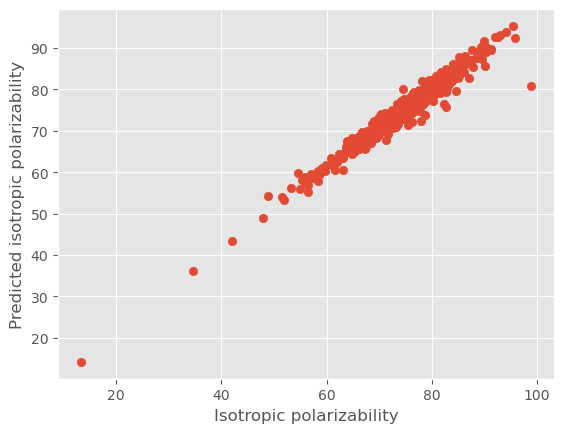

In [14]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.scatter(real[:500], predictions[:500])
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')